# Stock Market Prediction

In [1]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime

from sklearn.metrics import mean_squared_error
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot

C:\Users\udays\AppData\Local\Temp/ipykernel_5880/1242764530.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


C:\Users\udays\AppData\Local\Temp/ipykernel_5880/3361346621.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')


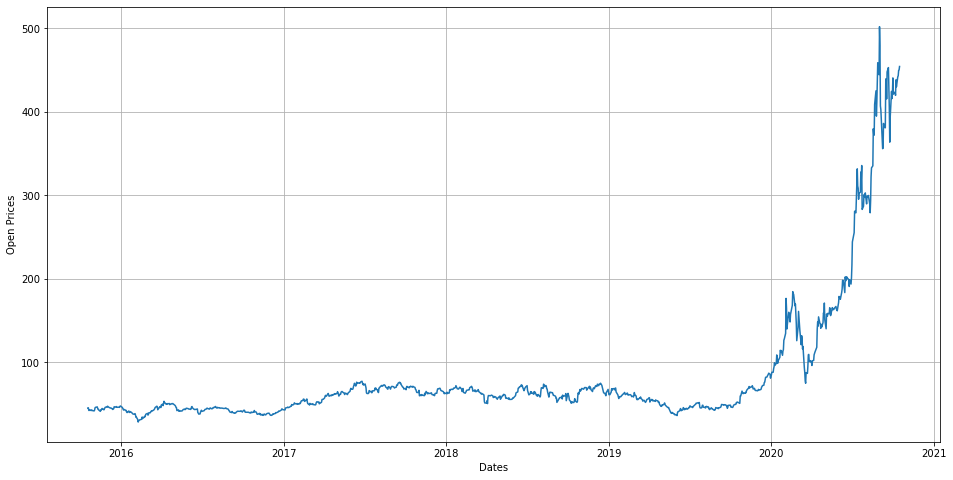

In [3]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('data/TSLA.csv', sep=',', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open']);

No handles with labels found to put in legend.


          t-1       t+1
t-1  1.000000  0.767892
t+1  0.767892  1.000000


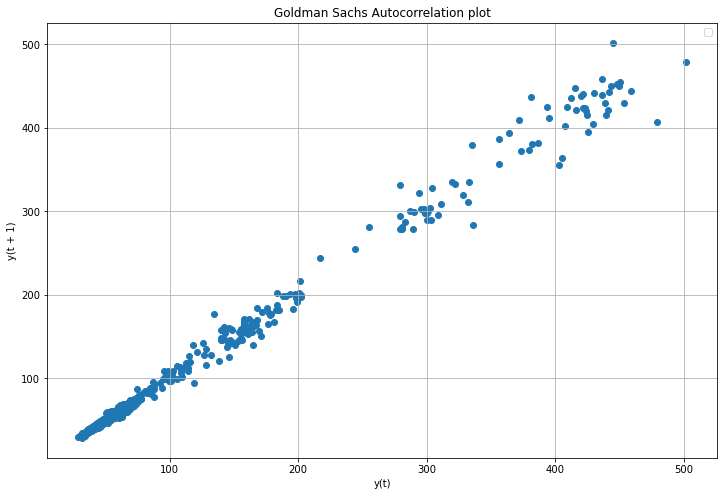

In [4]:
from pandas.plotting import lag_plot
plt.figure(figsize=(12,8))
lag_plot(data['Open'], lag=1)
plt.title('Goldman Sachs Autocorrelation plot')
plt.grid(True)
plt.legend();

from pandas import DataFrame
from pandas import concat
values = DataFrame(data['Open'].values)
dataframe = concat([values.shift(120), values], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

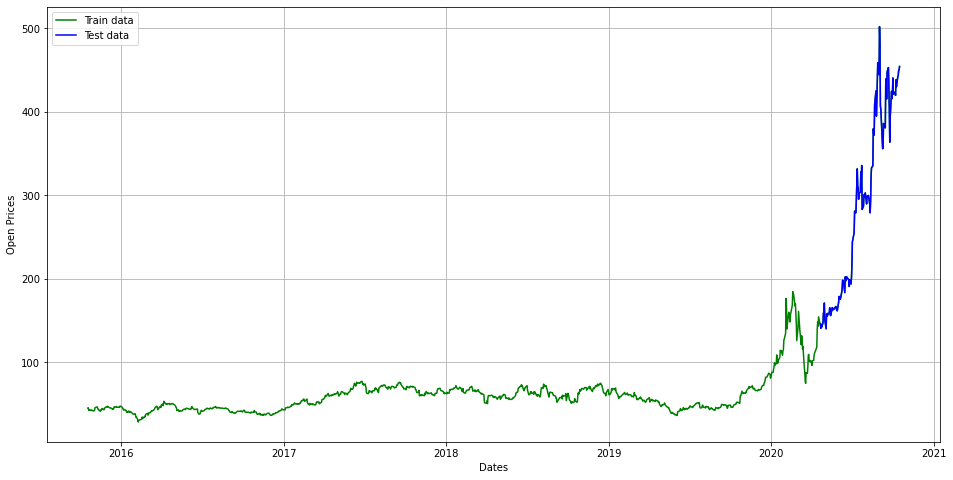

In [5]:
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'], 'green', label='Train data')
plt.plot(test_data['Open'], 'blue', label='Test data')
plt.legend()

# Existing System with R2 Scores

# LSTM

In [6]:
train = train_data.iloc[:, 0:1].values # selecting open prices

In [7]:
scaler = MinMaxScaler() #Feature Scaling
train_scaled = scaler.fit_transform(train)

In [8]:
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)

In [9]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) #Reshaping
from numpy.random import seed 
seed(2019)

In [10]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.20))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.25))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 50)             10400     
                                                                 
 dropout (Dropout)           (None, 7, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 7, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 7, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [13]:
model.fit(X_train, y_train, epochs = 40, batch_size = 32)

Epoch 1/40
36/36 [==============================] - 12s 18ms/step - loss: 0.0182
Epoch 2/40
36/36 [==============================] - 1s 35ms/step - loss: 0.0035
Epoch 3/40
36/36 [==============================] - 1s 29ms/step - loss: 0.0033
Epoch 4/40
36/36 [==============================] - 1s 29ms/step - loss: 0.0032
Epoch 5/40
36/36 [==============================] - 1s 27ms/step - loss: 0.0027
Epoch 6/40
36/36 [==============================] - 1s 21ms/step - loss: 0.0026
Epoch 7/40
36/36 [==============================] - 1s 19ms/step - loss: 0.0026
Epoch 8/40
36/36 [==============================] - 1s 19ms/step - loss: 0.0025
Epoch 9/40
36/36 [==============================] - 1s 15ms/step - loss: 0.0027
Epoch 10/40
36/36 [==============================] - 1s 20ms/step - loss: 0.0025
Epoch 11/40
36/36 [==============================] - 1s 28ms/step - loss: 0.0029
Epoch 12/40
36/36 [==============================] - 1s 29ms/step - loss: 0.0028
Epoch 13/40
36/36 [=================

In [14]:
real_stock_price = test_data.iloc[:,0:1].values

In [15]:
combine = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
# our test inputs also contains stock open Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)

In [16]:
test_data.shape

(126, 6)

In [17]:
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

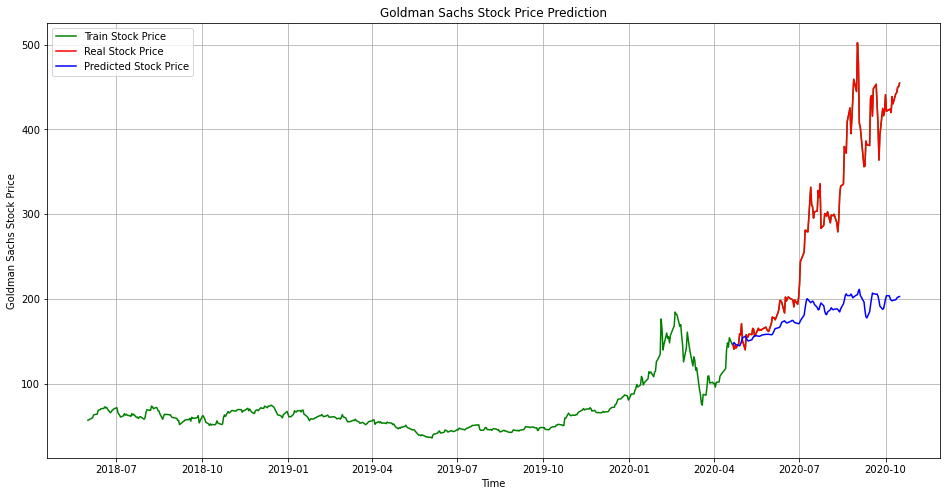

In [18]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('Goldman Sachs Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Goldman Sachs Stock Price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_30.pdf')
plt.show()

In [19]:
mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

MSE: 20072.36798290674
MAE: 108.57985793539187
RMSE: 141.67698466196526


# Machine Learning  Model

In [20]:
df = pd.read_csv('data/TSLA.csv')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


In [22]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace=True)

In [23]:
data = df.filter(['Close'])
dataset = data.values

In [24]:
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

1008

In [25]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.03595933],
       [0.02954091],
       [0.02828875],
       ...,
       [0.92116456],
       [0.89471577],
       [0.87510276]])

In [26]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

In [27]:
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.03595933, 0.02954091, 0.02828875, 0.02898298, 0.02786284,
       0.03049068, 0.02839949, 0.0295111 , 0.02894465, 0.02694289,
       0.0298646 , 0.02754767, 0.03746279, 0.03752241, 0.0377737 ,
       0.03477958, 0.03101881, 0.03211766, 0.02950259, 0.02705362,
       0.03008608, 0.02995404, 0.03296521, 0.03327612, 0.03251375,
       0.0315512 , 0.03176416, 0.03661523, 0.03745427, 0.03687929,
       0.03983083, 0.03761611, 0.03792277, 0.0369304 , 0.03724984,
       0.03537159, 0.03443459, 0.03552065, 0.03124028, 0.0319047 ,
       0.03297373, 0.0386894 , 0.03821239, 0.03696447, 0.03785888,
       0.03674727, 0.03664079, 0.03701132, 0.03632136, 0.03983083,
       0.04021415, 0.04103189, 0.03396183, 0.03397035, 0.03210062,
       0.0306568 , 0.02867633, 0.02733472, 0.02823764, 0.02412338])]
[0.02662345297136707]



In [28]:
x_train,y_train = np.array(x_train), np.array(y_train)

In [29]:
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1]))
x_train.shape

(948, 60)

# Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train,y_train)
val1 = model.score(x_train,y_train)
val1

0.9808361491205961

In [31]:
y_pred = model.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.9804617204447594

# Lasso Regression

In [32]:
from sklearn import linear_model
clf = linear_model.Lasso(alpha=0.1)
clf.fit(x_train,y_train)
val2 = clf.score(x_train,y_train)
val2

0.0

In [33]:
y_pred = clf.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

-1.184826486288866e+31

# Ridge regression

In [34]:
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)
clf.fit(x_train,y_train)
val3 = clf.score(x_train,y_train)
val3

0.8948435386548395

In [35]:
y_pred = clf.predict(x_train)

In [36]:
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.8608956836721915

# Proposed System

# XGBooster Regression

In [37]:
from xgboost import XGBRegressor
model = XGBRegressor()
model.fit(x_train,y_train)
val4 = model.score(x_train,y_train)
val4

0.9991262932837692

In [38]:
y_pred = model.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.9991224558480675

# Voting Regression

In [39]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor , VotingRegressor

In [40]:
r1 = DecisionTreeRegressor()
r2 = RandomForestRegressor(n_estimators=10, random_state=1)
r3 = SVR(C=1.0, epsilon=0.2)
er = VotingRegressor([('dt', r1), ('rf', r2), ('sv', r3)])

In [41]:
from sklearn.model_selection import GridSearchCV
params = {'dt': [1.0, 100.0],
          'rf': [1.0, 100.0],
      'sv': [2,3,4],}
grid = GridSearchCV(estimator=er, param_grid=params, cv=2)

In [42]:
er.fit(x_train,y_train)

VotingRegressor(estimators=[('dt', DecisionTreeRegressor()),
                            ('rf',
                             RandomForestRegressor(n_estimators=10,
                                                   random_state=1)),
                            ('sv', SVR(epsilon=0.2))])

In [43]:
val5 = er.score(x_train,y_train)
val5

0.8824071956243178

In [44]:
y_pred = er.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.7339379367580753

# Stacking Regression

In [45]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import SGDRegressor

In [46]:
estimators = [
...     ('ada', AdaBoostRegressor(random_state=0, n_estimators=100)),
...     ('sgd', SGDRegressor(max_iter=1000, tol=1e-3))
... ]

In [47]:
reg = StackingRegressor(
...     estimators=estimators,
...     final_estimator=XGBRegressor()
... )

In [48]:
reg.fit(x_train,y_train)

StackingRegressor(estimators=[('ada',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=0)),
                              ('sgd', SGDRegressor())],
                  final_estimator=XGBRegressor(base_score=None, booster=None,
                                               colsample_bylevel=None,
                                               colsample_bynode=None,
                                               colsample_bytree=None,
                                               enable_categorical=False,
                                               gamma=None, gpu_id=None,
                                               importance_type=None,
                                               interaction_constraints=None,
                                               learning_rate=None,
                                               max_delta_step=None,
                                               max_depth=

In [49]:
val6 = reg.score(x_train,y_train)
val6

0.9327387663008648

In [50]:
y_pred = reg.predict(x_train)
from sklearn.metrics import r2_score

r2_score(y_pred,y_train)

0.9206835064283903

# Deep Learning

In [51]:
data = pd.read_csv("data/TSLA.csv")

In [52]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-10-19,45.299999,46.230000,44.987999,45.619999,45.619999,12539500
1,2015-10-20,45.543999,45.720001,40.400002,42.605999,42.605999,74500000
2,2015-10-21,42.397999,42.962002,41.759998,42.018002,42.018002,20757500
3,2015-10-22,42.312000,43.150002,41.880001,42.344002,42.344002,14126000
4,2015-10-23,43.000000,43.070000,41.537998,41.818001,41.818001,21177500


In [53]:
length_data = len(data)     # rows that data has
split_ratio = 0.7           # %70 train + %30 validation
length_train = round(length_data * split_ratio)  
length_validation = length_data - length_train
print("Data length :", length_data)
print("Train data length :", length_train)
print("Validation data lenth :", length_validation)

Data length : 1259
Train data length : 881
Validation data lenth : 378


In [54]:
train_data = data[:length_train].iloc[:,:2] 
train_data['Date'] = pd.to_datetime(train_data['Date'])  # converting to date time object
train_data

,Date,Open
0,2015-10-19,45.299999
1,2015-10-20,45.543999
2,2015-10-21,42.397999
3,2015-10-22,42.312000
4,2015-10-23,43.000000
...,...,...
876,2019-04-12,54.043999
877,2019-04-15,53.726002
878,2019-04-16,53.150002
879,2019-04-17,54.950001


In [55]:
validation_data = data[length_train:].iloc[:,:2]
validation_data['Date'] = pd.to_datetime(validation_data['Date'])  # converting to date time object
validation_data

,Date,Open
881,2019-04-22,53.799999
882,2019-04-23,52.029999
883,2019-04-24,52.770000
884,2019-04-25,51.000000
885,2019-04-26,49.299999
...,...,...
1254,2020-10-12,442.000000
1255,2020-10-13,443.350006
1256,2020-10-14,449.779999
1257,2020-10-15,450.309998


In [56]:
dataset_train = train_data.Open.values
dataset_train.shape

(881,)

In [57]:
dataset_train = np.reshape(dataset_train, (-1,1))
dataset_train.shape

(881, 1)

In [58]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))


# scaling dataset
dataset_train_scaled = scaler.fit_transform(dataset_train)

dataset_train_scaled.shape

(881, 1)

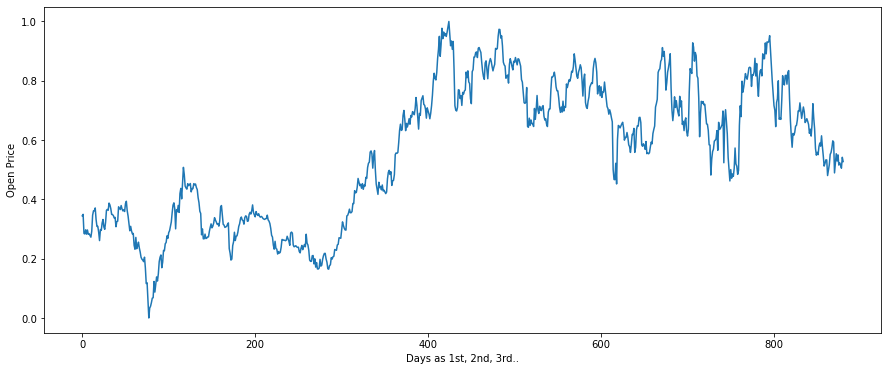

In [59]:
plt.subplots(figsize = (15,6))
plt.plot(dataset_train_scaled)
plt.xlabel("Days as 1st, 2nd, 3rd..")
plt.ylabel("Open Price")
plt.show()

In [60]:
X_train = []
y_train = []

time_step = 50

for i in range(time_step, length_train):
    X_train.append(dataset_train_scaled[i-time_step:i,0])
    y_train.append(dataset_train_scaled[i,0])
    
# convert list to array
X_train, y_train = np.array(X_train), np.array(y_train)

In [61]:
print("Shape of X_train before reshape :",X_train.shape)
print("Shape of y_train before reshape :",y_train.shape)

Shape of X_train before reshape : (831, 50)
Shape of y_train before reshape : (831,)


In [62]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
y_train = np.reshape(y_train, (y_train.shape[0],1))

print("Shape of X_train after reshape :",X_train.shape)
print("Shape of y_train after reshape :",y_train.shape)

Shape of X_train after reshape : (831, 50, 1)
Shape of y_train after reshape : (831, 1)


# Simple RNN

In [63]:
# importing libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

# initializing the RNN
regressor = Sequential()

# adding first RNN layer and dropout regulatization
regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True, 
              input_shape = (X_train.shape[1],1))
             )

regressor.add(
    Dropout(0.2)
             )


# adding second RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding third RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50, 
              activation = "tanh", 
              return_sequences = True)
             )

regressor.add(
    Dropout(0.2)
             )

# adding fourth RNN layer and dropout regulatization

regressor.add(
    SimpleRNN(units = 50)
             )

regressor.add(
    Dropout(0.2)
             )

# adding the output layer
regressor.add(Dense(units = 1))

# compiling RNN
regressor.compile(
    optimizer = "adam", 
    loss = "mean_squared_error",
    metrics = ["accuracy"])


In [64]:
# fitting the RNN
history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
26/26 [==============================] - 7s 63ms/step - loss: 0.4932 - accuracy: 0.0024
Epoch 2/100
26/26 [==============================] - 2s 61ms/step - loss: 0.2784 - accuracy: 0.0012
Epoch 3/100
26/26 [==============================] - 2s 61ms/step - loss: 0.2402 - accuracy: 0.0012
Epoch 4/100
26/26 [==============================] - 1s 50ms/step - loss: 0.2200 - accuracy: 0.0000e+00
Epoch 5/100
26/26 [==============================] - 1s 48ms/step - loss: 0.1591 - accuracy: 0.0024
Epoch 6/100
26/26 [==============================] - 1s 50ms/step - loss: 0.1476 - accuracy: 0.0024
Epoch 7/100
26/26 [==============================] - 1s 36ms/step - loss: 0.1120 - accuracy: 0.0024
Epoch 8/100
26/26 [==============================] - 1s 36ms/step - loss: 0.1011 - accuracy: 0.0012
Epoch 9/100
26/26 [==============================] - 1s 36ms/step - loss: 0.0866 - accuracy: 0.0024
Epoch 10/100
26/26 [==============================] - 1s 36ms/step - loss: 0.0895 - accuracy: 0.

26/26 [==============================] - 2s 65ms/step - loss: 0.0060 - accuracy: 0.0024
Epoch 83/100
26/26 [==============================] - 2s 65ms/step - loss: 0.0059 - accuracy: 0.0024
Epoch 84/100
26/26 [==============================] - 2s 66ms/step - loss: 0.0061 - accuracy: 0.0024
Epoch 85/100
26/26 [==============================] - 2s 65ms/step - loss: 0.0054 - accuracy: 0.0024
Epoch 86/100
26/26 [==============================] - 2s 67ms/step - loss: 0.0051 - accuracy: 0.0024
Epoch 87/100
26/26 [==============================] - 2s 67ms/step - loss: 0.0057 - accuracy: 0.0024
Epoch 88/100
26/26 [==============================] - 2s 66ms/step - loss: 0.0055 - accuracy: 0.0024
Epoch 89/100
26/26 [==============================] - 1s 53ms/step - loss: 0.0054 - accuracy: 0.0024
Epoch 90/100
26/26 [==============================] - 1s 27ms/step - loss: 0.0053 - accuracy: 0.0024
Epoch 91/100
26/26 [==============================] - 1s 32ms/step - loss: 0.0054 - accuracy: 0.0024
Epo

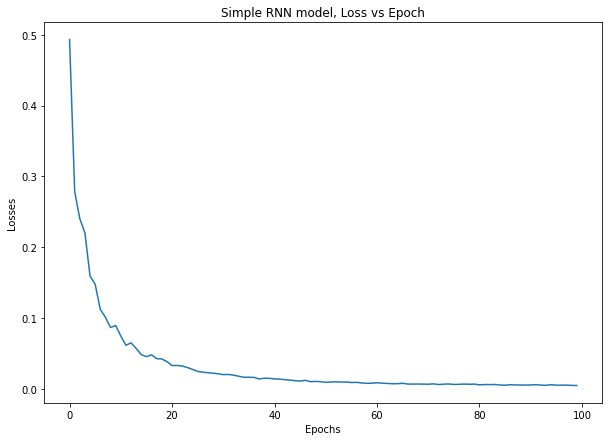

In [65]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

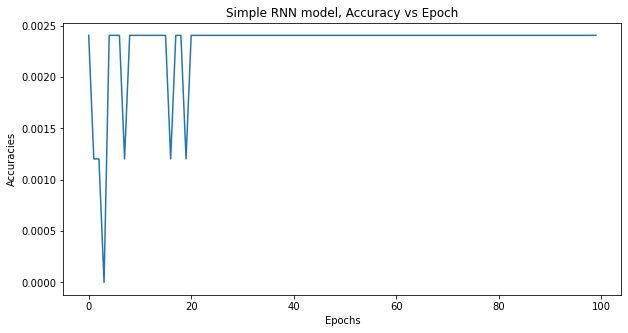

In [66]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("Simple RNN model, Accuracy vs Epoch")
plt.show()

# CNN

In [68]:
import tensorflow as tf
import keras
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for dilation_rate in (1, 2, 4, 8, 16, 32):
    model.add(
      keras.layers.Conv1D(filters=32,
                          kernel_size=2,
                          strides=1,
                          dilation_rate=dilation_rate,
                          padding="causal",
                          activation="relu")
    )

model.add(keras.layers.Conv1D(filters=1, kernel_size=1))
lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 30))

optimizer = tf.keras.optimizers.Nadam(lr=1e-4)

C:\Users\udays\anaconda3\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


In [69]:
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [70]:
# save best model 
model_checkpoint = keras.callbacks.ModelCheckpoint(
    "my_checkpoint.h5", save_best_only=True)

# set early stopping
early_stopping = keras.callbacks.EarlyStopping(patience=50)


In [71]:
# sav history
history = model.fit(X_train, y_train, epochs=20)

Epoch 1/20
26/26 [==============================] - 2s 8ms/step - loss: 0.1829 - mae: 0.5589
Epoch 2/20
26/26 [==============================] - 0s 9ms/step - loss: 0.1562 - mae: 0.5114
Epoch 3/20
26/26 [==============================] - 0s 10ms/step - loss: 0.1135 - mae: 0.4242
Epoch 4/20
26/26 [==============================] - 0s 12ms/step - loss: 0.0589 - mae: 0.2783
Epoch 5/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0343 - mae: 0.2029
Epoch 6/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0275 - mae: 0.1810
Epoch 7/20
26/26 [==============================] - 0s 11ms/step - loss: 0.0222 - mae: 0.1619
Epoch 8/20
26/26 [==============================] - 0s 11ms/step - loss: 0.0181 - mae: 0.1469
Epoch 9/20
26/26 [==============================] - 0s 9ms/step - loss: 0.0153 - mae: 0.1378
Epoch 10/20
26/26 [==============================] - 0s 8ms/step - loss: 0.0133 - mae: 0.1305
Epoch 11/20
26/26 [==============================] - 0s 8ms/step 

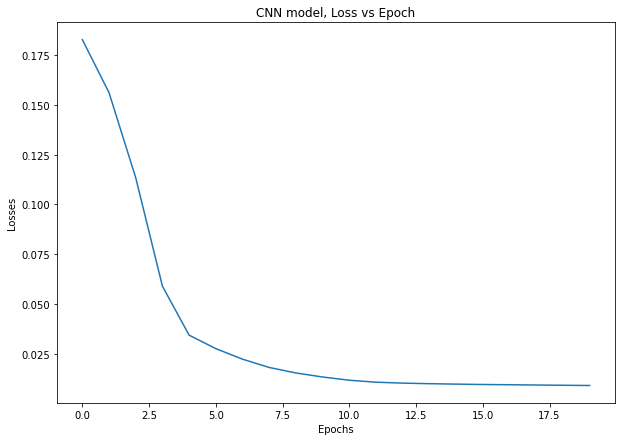

In [72]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("CNN model, Loss vs Epoch")
plt.show()

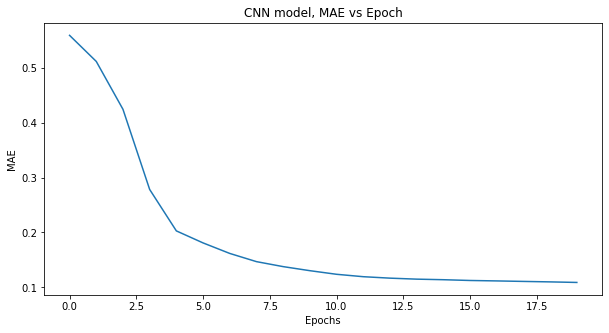

In [73]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["mae"])
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.title("CNN model, MAE vs Epoch")
plt.show()